# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#1e9570; border-radius: 100px 100px; text-align:center">Import Required Libraries</h1></span> <a class='anchor' id='install'></a>

In [1]:
# Data Processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import rcParams

# Main Library
import torch 
from torch import nn
# Setup device agnostic code (Using GPU)
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu" 


In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

GPU is not available, using CPU


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#1e9570; border-radius: 100px 100px; text-align:center">Proper Data Cleaning 📚</h1></span>  <a class='anchor' id='import'></a>

In [4]:
df_0= pd.read_csv('data/adult.csv')
df = df_0.copy()
Rnd_seed = 123

In [5]:
def find_features_with_missing_values(df):
    # Replace characters with NaN
    replace_chars = ["\n", "\n?\n", "?","\n?"," ?","? "," ? "," ?\n"]
    if any(char in df.values for char in replace_chars):
        df.replace(replace_chars, np.nan, inplace=True)
        print("Successfully replaced characters with NaN.")
    
    # Find features with missing values
    features_with_null = [feature for feature in df.columns if df[feature].isnull().sum() > 0]
    if not features_with_null:
        print("No missing values found in any features.")
    else:
        for feature in features_with_null:
            print(f"{feature}: {round(df[feature].isnull().mean() * 100, 2)}%")
    return features_with_null


In [6]:
find_features_with_missing_values(df)

Successfully replaced characters with NaN.
workclass: 5.64%
occupation: 5.66%
native.country: 1.79%


['workclass', 'occupation', 'native.country']

In [7]:
# Change NaN values with "missing"
df = df.fillna("Missing")

In [8]:
# Rename the columns
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
              'marital-status', 'occupation', 'relationship', 'race', 'sex',
              'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
              'income']

In [9]:
# show the same  "Missing" and their "income" values for native country
df[df["native-country"] == "Missing"]["income"].value_counts(normalize=True)

1       0.749571
>50K    0.250429
Name: income, dtype: float64

>Note: Class target is  25% for "Missing" country. So, decided to keep them since the dataset is already imbalanecd

In [10]:
# Clean up occupation column by removing any leading/trailing spaces
df['occupation'] = df['occupation'].str.strip()
# Replace occupation categories with new categories
df['new_occupation'] = df['occupation'].replace({
    'Prof-specialty': 'Professional_Managerial',
    'Craft-repair': 'Skilled_Technical',
    'Exec-managerial': 'Professional_Managerial',
    'Adm-clerical': 'Sales_Administrative',
    'Sales': 'Sales_Administrative',
    'Other-service': 'Service_Care',
    'Machine-op-inspct': 'Skilled_Technical',
    'Missing': 'Unclassified Occupations',
    'Transport-moving': 'Skilled_Technical',
    'Handlers-cleaners': 'Service_Care',
    'Farming-fishing': 'Service_Care',
    'Tech-support': 'Skilled_Technical',
    'Protective-serv': 'Professional_Managerial',
    'Priv-house-serv': 'Service_Care',
    'Armed-Forces': 'Unclassified Occupations',
})

# Check value counts of new occupation column
df.drop(['occupation'], axis=1,inplace=True)
print(f"New narrowed categories : \n{df['new_occupation'].value_counts()}")

New narrowed categories : 
Professional_Managerial     8855
Skilled_Technical           8626
Sales_Administrative        7420
Service_Care                5808
Unclassified Occupations    1852
Name: new_occupation, dtype: int64


In [11]:
data_types = {'age': 'uint8',
               'workclass': 'category',
               'fnlwgt': 'int32',
               'education': 'category',
               'education-num': 'uint8',
               'marital-status': 'category',
               'new_occupation': 'category',
               'relationship': 'category',
               'race': 'category',
               'sex': 'category',
               'capital-gain': 'int32',
               'capital-loss': 'int32',
               'hours-per-week': 'uint8',
               'native-country': 'category',
               'income': 'category'}
df = df.astype(data_types)

# drop education and native country columns
df.drop(['education'], axis=1,inplace=True)
df.drop(['native-country'], axis=1,inplace=True)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#1e9570; border-radius: 100px 100px; text-align:center">Exploratory Data Analysis (EDA) 🔍</h1></span> <a class='anchor' id='eda'></a>
 

<Axes: xlabel='age', ylabel='Density'>

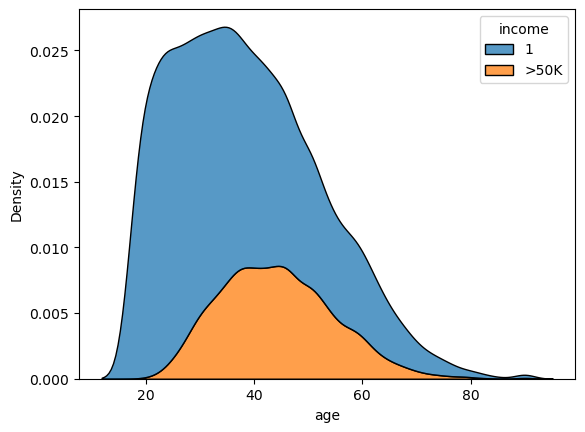

In [12]:
# Visualize Target Class (Income)
columns = list(df.columns)
sns.kdeplot(data=df, x=columns.pop(0), hue="income", multiple="stack")

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'fnlwgt'}>],
       [<Axes: title={'center': 'education-num'}>,
        <Axes: title={'center': 'capital-gain'}>],
       [<Axes: title={'center': 'capital-loss'}>,
        <Axes: title={'center': 'hours-per-week'}>]], dtype=object)

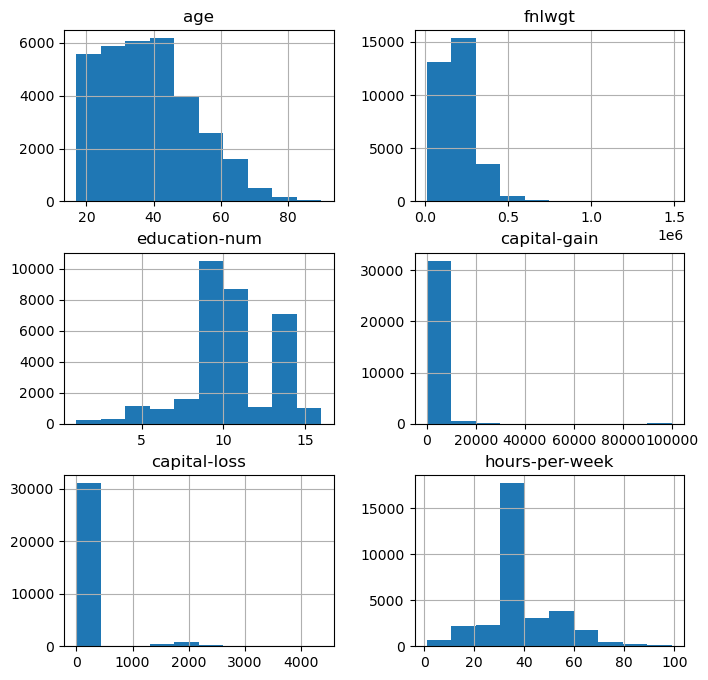

In [13]:
#Visualizing the numerical features of the dataset using histograms to analyze the distribution of those features in the dataset

rcParams['figure.figsize'] = 8, 8
df[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']].hist()


<Axes: xlabel='income', ylabel='count'>

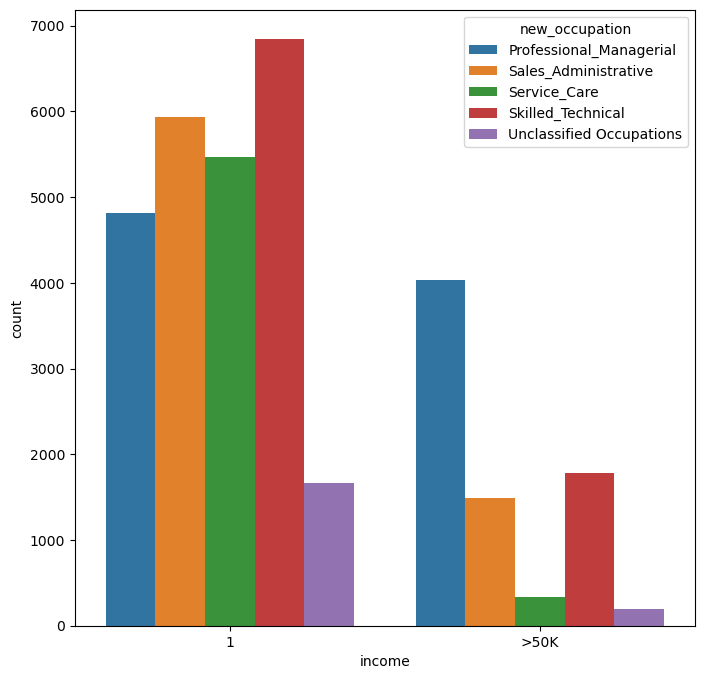

In [14]:
sns.countplot(x = 'income', hue = 'new_occupation', data = df)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#1e9570; border-radius: 100px 100px; text-align:center">Process 1 : Only Label Encoding Applied 🌌</h1></span> <a class='anchor' id='tsne'></a>
 

In [15]:

label_encoder = LabelEncoder()
df_encoded = df.copy()  # Create a copy of the DataFrame for encoded values

# Apply label encoding to each categorical column
categorical_columns = ['workclass', 'marital-status', 'new_occupation', 'relationship', "race",'sex', 'income']
for column in categorical_columns:
    df_encoded[column] = label_encoder.fit_transform(df[column])

# The encoded DataFrame df_encoded now contains the label encoded values

In [16]:
X = df_encoded.drop(['income'], axis=1)
y = df_encoded['income']
X, y = X.to_numpy(), y.to_numpy() # turn df to numpy arrays

In [17]:
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float) 
y = torch.from_numpy(y).type(torch.float)

# Apply split function to split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = Rnd_seed)
print(f"Train shapes : {X_train.shape, y_train.shape}")
print(f" Test shapes : {X_test.shape, y_test.shape}")                                                                                                

Train shapes : (torch.Size([22792, 12]), torch.Size([22792]))
 Test shapes : (torch.Size([9769, 12]), torch.Size([9769]))


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#1e9570; border-radius: 100px 100px; text-align:center">Feedforward NN (without dropout) a simple version of the model 🛠️</h1></span> <a class='anchor' id='data'></a>

 

In [18]:
# Check if GPU is available

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

GPU is not available, using CPU


In [19]:
# Inherit from nn.Module to make a model 
class Classification_AdultCensus(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=12, out_features=128)
        self.layer_2 = nn.Linear(in_features=128,out_features=64)
        self.layer_3 = nn.Linear(in_features=64,out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor ) -> torch.Tensor:
        network = self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
        return network

# Instantiate the model

model_1 = Classification_AdultCensus()
# SEND IT TO THE TARGET DEVICE
model_1 = Classification_AdultCensus().to(DEVICE)
## Your code here ##
model_1

Classification_AdultCensus(
  (layer_1): Linear(in_features=12, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [20]:
# Setup loss function Binary cross entropy
Binary_Loss = nn.BCEWithLogitsLoss() # NO logloss ? 
# Setup optimizer to optimize model's parameters
opt = torch.optim.SGD(model_1.parameters(),
                      lr=0.01) # lr = learning rate 

In [21]:


# Set up the optimizer and loss function
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

torch.manual_seed(42)

# Set the number of epochs
epochs = 10000

# Put data to the target device
X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

# Build the training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()
    optimizer.zero_grad()

    # Forward pass
    y_logits = model_1(X_train).squeeze()
    loss = criterion(y_logits, y_train)
  
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.no_grad():
        test_logits = model_1(X_test).squeeze()
        test_loss = criterion(test_logits, y_test)
        test_pred = torch.round(torch.sigmoid(test_logits))

    if epoch % 2000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}")

train_pred = torch.round(torch.sigmoid(model_1(X_train).squeeze()))
test_pred = torch.round(torch.sigmoid(model_1(X_test).squeeze()))
train_score_0 = classification_report(y_train.cpu().detach().numpy(), train_pred.cpu().detach().numpy(), zero_division=1,digits=4,target_names=['<=50K', '>50K'])
test_score_0 = classification_report(y_test.cpu().detach().numpy(), test_pred.cpu().detach().numpy(), zero_division=1,digits=4,target_names=['<=50K', '>50K'])

print(f"\nTrain Classification Report:\n{train_score_0}")
print(f"\nTest Classification Report:\n{test_score_0}")


Epoch: 0 | Loss: 5228.7021 | Test Loss: 190233083904.0000
Epoch: 2000 | Loss: 0.5516 | Test Loss: 0.5530
Epoch: 4000 | Loss: 0.5516 | Test Loss: 0.5530
Epoch: 6000 | Loss: 0.5516 | Test Loss: 0.5530
Epoch: 8000 | Loss: 0.5516 | Test Loss: 0.5530

Train Classification Report:
              precision    recall  f1-score   support

       <=50K     0.7596    1.0000    0.8634     17312
        >50K     1.0000    0.0000    0.0000      5480

    accuracy                         0.7596     22792
   macro avg     0.8798    0.5000    0.4317     22792
weighted avg     0.8174    0.7596    0.6558     22792


Test Classification Report:
              precision    recall  f1-score   support

       <=50K     0.7583    1.0000    0.8625      7408
        >50K     1.0000    0.0000    0.0000      2361

    accuracy                         0.7583      9769
   macro avg     0.8792    0.5000    0.4313      9769
weighted avg     0.8167    0.7583    0.6541      9769



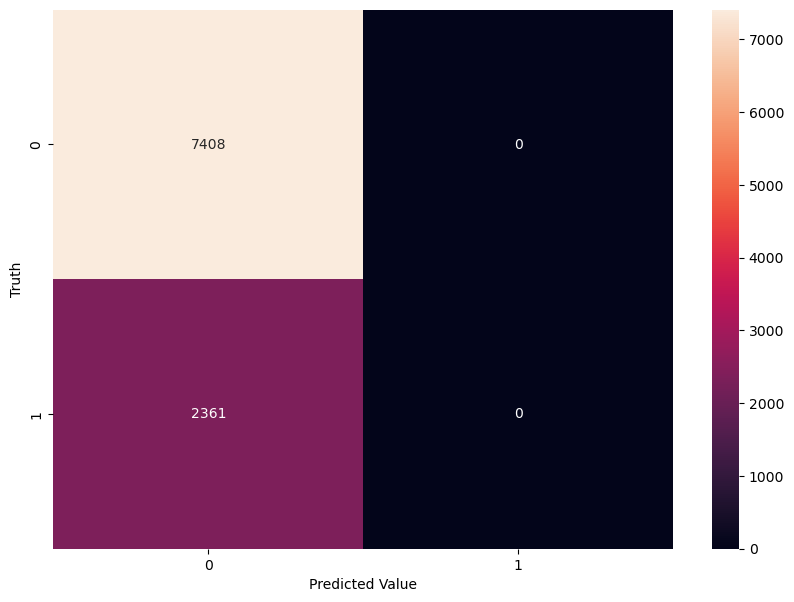

In [22]:

y_test_np = y_test.cpu().detach().numpy().astype(int)  # Convert y_test to NumPy array of integers
test_pred_np = test_pred.cpu().detach().numpy().astype(int)  # Convert test_pred to NumPy array of integers

cm = confusion_matrix(y_test_np, test_pred_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Value")
plt.ylabel("Truth")
plt.show()

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#1e9570; border-radius: 100px 100px; text-align:center">Process 2: One hot encoding, Standardization 📊</h1></span> <a class='anchor' id='ml'></a>

 

In [23]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Apply label encoding to the specified variables
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()
le5 = LabelEncoder()
le6 = LabelEncoder()

# Encode the categorical columns as numeric labels
df['workclass'] = le1.fit_transform(df['workclass'])
df['marital-status'] = le2.fit_transform(df['marital-status'])
df['new_occupation'] = le3.fit_transform(df['new_occupation'])
df['relationship'] = le4.fit_transform(df['relationship'])
df['race'] = le5.fit_transform(df['race'])
df['sex'] = le6.fit_transform(df['sex'])

# Create instances of the OneHotEncoder class, specifying which columns to drop
ohe1 = OneHotEncoder(drop='first')
ohe2 = OneHotEncoder(drop='first')
ohe3 = OneHotEncoder(drop='first')
ohe4 = OneHotEncoder(drop='first')
ohe5 = OneHotEncoder(drop='first')
ohe6 = OneHotEncoder(drop='first')

# Fit and transform the categorical features using one-hot encoding
workclass_encoded = ohe1.fit_transform(df[['workclass']]).toarray()
marital_encoded = ohe2.fit_transform(df[['marital-status']]).toarray()
occupation_encoded = ohe3.fit_transform(df[['new_occupation']]).toarray()
relationship_encoded = ohe4.fit_transform(df[['relationship']]).toarray()
race_encoded = ohe5.fit_transform(df[['race']]).toarray()
sex_encoded = ohe6.fit_transform(df[['sex']]).toarray()

# Convert the encoded features to pandas DataFrames
workclass_array = pd.DataFrame(workclass_encoded, columns=ohe1.get_feature_names_out())
marital_array = pd.DataFrame(marital_encoded, columns=ohe2.get_feature_names_out())
occupation_array = pd.DataFrame(occupation_encoded, columns=ohe3.get_feature_names_out())
relationship_array = pd.DataFrame(relationship_encoded, columns=ohe4.get_feature_names_out())
race_array = pd.DataFrame(race_encoded, columns=ohe5.get_feature_names_out())
sex_array = pd.DataFrame(sex_encoded, columns=ohe6.get_feature_names_out())

# Drop the original categorical features
df_dropped = df.drop(['workclass', 'marital-status', 'new_occupation', 'relationship', 'race', 'sex'], axis=1)

# Concatenate the encoded features with the numerical features
df_encoded = pd.concat([workclass_array, marital_array, occupation_array, relationship_array, race_array, sex_array, df_dropped], axis=1)

# Print the shape and the first three rows of the encoded dataset
print(df_encoded.shape)
print(df_encoded.head(3))


(32561, 35)
   workclass_1  workclass_2  workclass_3  workclass_4  workclass_5  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          1.0   
2          0.0          0.0          1.0          0.0          0.0   

   workclass_6  workclass_7  workclass_8  marital-status_1  marital-status_2  \
0          1.0          0.0          0.0               0.0               0.0   
1          0.0          0.0          0.0               0.0               1.0   
2          0.0          0.0          0.0               0.0               0.0   

   ...  race_3  race_4  sex_1  age  fnlwgt  education-num  capital-gain  \
0  ...     0.0     1.0    1.0   39   77516             13          2174   
1  ...     0.0     1.0    1.0   50   83311             13             0   
2  ...     0.0     1.0    1.0   38  215646              9             0   

   capital-loss  hours-per-week  income  
0             0              40       1  
1

In [24]:
#apply only label encoding to target variable
le = LabelEncoder()
df_encoded['income'] = le.fit_transform(df_encoded['income'])

In [25]:
X = df_encoded.drop(['income'], axis=1)
y = df_encoded['income']
# Turn X,y to numpy aray
X = X.to_numpy()
y = y.to_numpy()
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float) # better way of doing it 
y = torch.from_numpy(y).type(torch.float)
# Apply split function to split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = Rnd_seed)
print(f"Train shapes : {X_train.shape, y_train.shape}")
print(f" Test shapes : {X_test.shape, y_test.shape}")   

Train shapes : (torch.Size([22792, 34]), torch.Size([22792]))
 Test shapes : (torch.Size([9769, 34]), torch.Size([9769]))


Apply Standardization to numerical variables

In [26]:
from sklearn.preprocessing import StandardScaler

# Define the columns to standardize
columns_to_standardize = [28, 29, 30, 31, 32, 33]

# Create a StandardScaler object
scaler = StandardScaler()

# Convert X_train and X_test to NumPy arrays
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()

# Fit the scaler on the training data columns
scaler.fit(X_train_np[:, columns_to_standardize])

# Standardize the selected columns in both X_train and X_test
X_train_np[:, columns_to_standardize] = scaler.transform(X_train_np[:, columns_to_standardize])
X_test_np[:, columns_to_standardize] = scaler.transform(X_test_np[:, columns_to_standardize])

# Convert back to PyTorch tensors
X_train = torch.from_numpy(X_train_np).type(torch.float) 
X_test = torch.from_numpy(X_test_np).type(torch.float)


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#1e9570; border-radius: 100px 100px; text-align:center">Feedforward NN with dropout a complex version of the model</h1></span> <a class='anchor' id='result'></a>

 

In [27]:
import torch.nn.functional as F

class Classification_AdultCensus(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=34, out_features=64)
        self.layer_2 = nn.Linear(in_features=64, out_features=128)
        self.layer_3 = nn.Linear(in_features=128, out_features=64)
        self.layer_4 = nn.Linear(in_features=64, out_features=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.dropout(self.relu(self.layer_1(x)))
        x = self.dropout(self.relu(self.layer_2(x)))
        x = self.dropout(self.relu(self.layer_3(x)))
        network = self.layer_4(x)
        return network

# Instantiate the model
model_1 = Classification_AdultCensus().to(DEVICE)


In [28]:


# Set up the optimizer and loss function
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

torch.manual_seed(42)

# Set the number of epochs
epochs = 10000

# Put data to the target device
X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

# Build the training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()
    optimizer.zero_grad()

    # Forward pass
    y_logits = model_1(X_train).squeeze()
    loss = criterion(y_logits, y_train)
  
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.no_grad():
        test_logits = model_1(X_test).squeeze()
        test_loss = criterion(test_logits, y_test)
        test_pred = torch.round(torch.sigmoid(test_logits))

    if epoch % 2000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}")

train_pred = torch.round(torch.sigmoid(model_1(X_train).squeeze()))
test_pred = torch.round(torch.sigmoid(model_1(X_test).squeeze()))
train_score = classification_report(y_train.cpu().detach().numpy(), train_pred.cpu().detach().numpy(), zero_division=1,digits=4,target_names=['<=50K', '>50K'])
test_score = classification_report(y_test.cpu().detach().numpy(), test_pred.cpu().detach().numpy(), zero_division=1,digits=4,target_names=['<=50K', '>50K'])

print(f"\nTrain Classification Report:\n{train_score}")
print(f"\nTest Classification Report:\n{test_score}")


Epoch: 0 | Loss: 0.7041 | Test Loss: 0.7034
Epoch: 2000 | Loss: 0.3822 | Test Loss: 0.3789
Epoch: 4000 | Loss: 0.3319 | Test Loss: 0.3269


KeyboardInterrupt: 

In [ ]:

y_test_np = y_test.cpu().detach().numpy().astype(int)  # Convert y_test to NumPy array of integers
test_pred_np = test_pred.cpu().detach().numpy().astype(int)  # Convert test_pred to NumPy array of integers

cm = confusion_matrix(y_test_np, test_pred_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Value")
plt.ylabel("Truth")
plt.show()

In [ ]:
print(f"\n Test Classification Report of the FIRST process :\n{test_score_0}")
print(f"\n Test Classification Report of the SECOND process :\n{test_score}")